In [1]:
%matplotlib inline
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Check tissue specificity for variable selection.
tissue_to_genes = collections.defaultdict(list)
genes_to_tissue = collections.defaultdict(set)
with open("train.tsv") as f:
    for line in f:
        line = line.rstrip().split()
        tissue = line[1]
        snvs = line[2].split("|")
        tissue_to_genes[tissue] += snvs
        for snv in snvs:
            genes_to_tissue[snv].add(tissue)

selected_genes = set()
for gene in genes_to_tissue:
    c = collections.Counter(genes_to_tissue[gene])
    if len(c.most_common()) < 3:
        selected_genes.add(gene)

participating_genes = set()
for tissue in tissue_to_genes:
    c = collections.Counter(tissue_to_genes[tissue])
    participating_genes.update([i[0] for i in c.most_common(450)])

# Add genes that are often common in the genes to the dataset.
selected_genes = selected_genes | participating_genes
    
selected_genes = list(selected_genes)

In [3]:
# Create the function to convert a gene list to a vector.
def vectorize(gene_list, num_ins, num_del):
    insert = np.zeros(24)
    delete = np.zeros(24)
    v = np.zeros(len(selected_genes))
    for i in xrange(len(selected_genes)):
        if selected_genes[i] in gene_list:
            v[i] = 1
    
    for i in xrange(len(insert)):
        ind = i+1
        if ind in num_ins:
            insert[i] = 1
        elif ind in num_del:
            delete[i] = 1
    

    v = np.concatenate((v, insert))
    v = np.concatenate((v, delete))
    return v

In [4]:
# Read the training dataset.
train_x = []
train_y = []
sexual_chromosome = {'X':23, 'Y':24}
chromosome = lambda x : sexual_chromosome.get(x, int(x))
with open("train.tsv") as f:
    for line in f:
        line = line.rstrip().split()
        tissue = line[1]
        snvs = line[2]
        num_ins = set(map(lambda x: chromosome(x.lstrip('chr')), filter(lambda x : 'chr' in x, line[3].replace(':', '|').split('|'))))
        num_del = set(map(lambda x: chromosome(x.lstrip('chr')), filter(lambda x : 'chr' in x, line[4].replace(':', '|').split('|'))))
        train_y.append(tissue)
        train_x.append(vectorize(snvs.split("|"), num_ins, num_del))
        
_train_y = []
unique_tissues = list(set(train_y))
for y in train_y:
    _train_y.append(unique_tissues.index(y))
train_y = _train_y

train_x = np.array(train_x)
train_y = np.array(train_y)

In [5]:
# Read the test dataset.
test_x = []
test_y = []
with open("test.tsv") as f:
    for line in f:
        line = line.rstrip().split()
        tissue = line[1]
        snvs = line[2]
        num_ins = set(map(lambda x: chromosome(x.lstrip('chr')), filter(lambda x : 'chr' in x, line[3].replace(':', '|').split('|'))))
        num_del = set(map(lambda x: chromosome(x.lstrip('chr')), filter(lambda x : 'chr' in x, line[4].replace(':', '|').split('|'))))
        #num_ins = len(line[3].split("|")) if line[3] != "*" else 0
        #num_del = len(line[4].split("|")) if line[4] != "*" else 0
        test_y.append(tissue)
        test_x.append(vectorize(snvs.split("|"), num_ins, num_del))
        
_test_y = []
unique_tissues = list(set(test_y))
for y in test_y:
    _test_y.append(unique_tissues.index(y))
test_y = _test_y

test_x = np.array(test_x)
test_y = np.array(test_y)

In [6]:
test_x.shape

(500, 11150)

In [7]:
# Use dimensionality reduction.
pca = PCA(n_components=900)
pca.fit(train_x)

PCA(copy=True, n_components=900, whiten=False)

In [8]:
# Transform
pca_train = pca.transform(train_x)
pca_test = pca.transform(test_x)

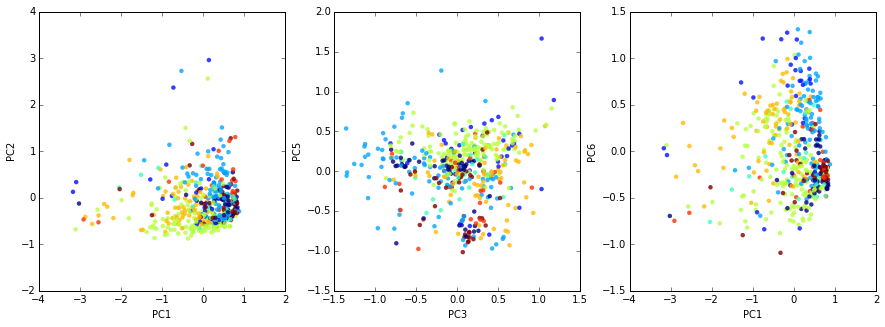

In [9]:
# Plot some PCs.
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=test_y, edgecolor='none', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 3, 2)
plt.scatter(pca_test[:, 2], pca_test[:, 4], c=test_y, edgecolor='none', alpha=0.8)
plt.xlabel("PC3")
plt.ylabel("PC5")

plt.subplot(1, 3, 3)
plt.scatter(pca_test[:, 0], pca_test[:, 3], c=test_y, edgecolor='none', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC6")

In [10]:
# Train the model.
svc = LinearSVC()
svc.fit(pca_train, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Test the model.
svc.score(pca_test, test_y)

0.78200000000000003

In [ ]:
# Read the test dataset.
out = open("output.tsv", "wb")
with open("validation_masked.tsv") as f:
    for line in f:
        line = line.rstrip().split()
        snvs = line[2]
        num_ins = set(map(lambda x: chromosome(x.lstrip('chr')), filter(lambda x : 'chr' in x, line[3].replace(':', '|').split('|'))))
        num_del = set(map(lambda x: chromosome(x.lstrip('chr')), filter(lambda x : 'chr' in x, line[4].replace(':', '|').split('|'))))
        #num_ins = len(line[3].split("|")) if line[3] != "*" else 0
        #num_del = len(line[4].split("|")) if line[4] != "*" else 0
        v = vectorize(snvs.split("|"), num_ins, num_del)
        v_pca = pca.transform(v)
        pred = svc.predict(v_pca)
        pred_class = unique_tissues[pred]
        out.write(line[0] + "\t" + pred_class + "\t" + "\t".join(line[2:]) + "\n")
out.close()